# Bayesian Logistic Regression

In this notebook we show how a logistic regression compares between the traditional machine learning approach and the Bayesian approach. As we will see, setting up a Bayesian model will be less straightforward. However, the predictions made with the Bayesian approach will generalise better and will be easier to inspect. 

In [1]:
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy import integrate, stats
from scipy.special import expit as logistic
from sklearn.linear_model import LogisticRegression

matplotlib.rcParams["figure.dpi"] = 300
rng = np.random.default_rng(seed=42)

## Visualise the data

The data that we wish to model is hard coded, centered at zero, and reads as follows.

In [2]:
X = np.array(
    [
        [0.84, -1.48],
        [-4.64, -4.08],
        [1.32, -7.64],
        [-3.04, -6.64],
        [-8.8, -10.48],
        [-0.84, 1.48],
        [4.64, 4.08],
        [-1.32, 7.64],
        [3.04, 6.64],
        [8.8, 10.48],
    ]
)

y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

The data looks like this.

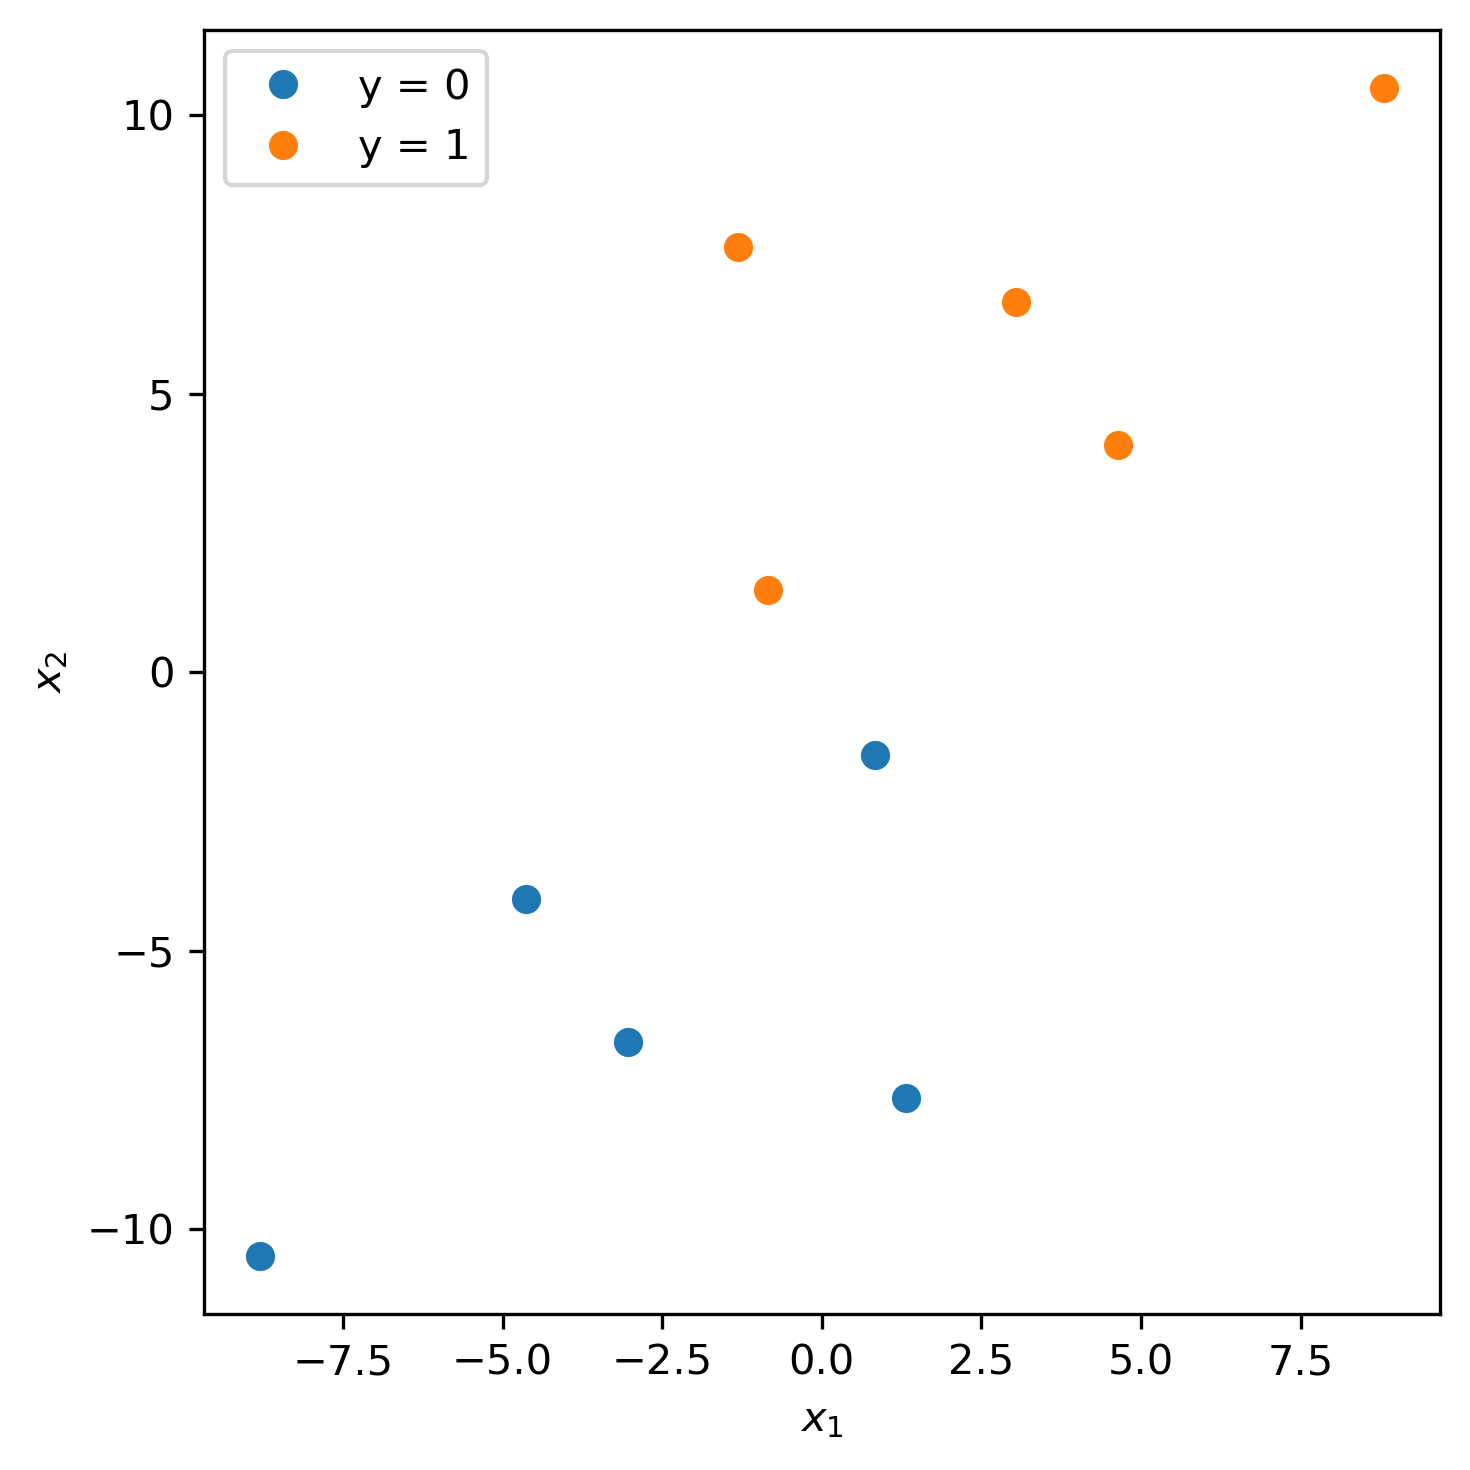

In [3]:
f, ax = plt.subplots(figsize=(5, 5))

ax.plot(*X[:5].T, "o", ms=8, mec="w", label="y = 0")
ax.plot(*X[5:].T, "o", ms=8, mec="w", label="y = 1")
ax.set(xlabel="$x_1$", ylabel="$x_2$")
ax.legend()

f.tight_layout()
plt.show()

## Conventional ML

First let's fit a regular logistic regression to this data using Scikit-learn.

In [4]:
model = LogisticRegression(fit_intercept=False, C=1)
model.fit(X, y)

LogisticRegression(C=1, fit_intercept=False)

#### What's going on under the hood?

The class LogisticRegression contains a hard-coded cost function given by:

$$ Cost(y, x, \theta) = \frac{1}{2} \theta \cdot \theta + C\sum_{i=1}^{n} (y_i \log p_i) + (1 - y_i)\log(1 - p_i)) $$

where, $p = \mathrm{logistic}(X_i\cdot \theta)$. 

The second term is saying that the data follows a Bernoulli distribution, because that term is equal to the log-likelihood of a Bernoulli distribution with proabability $p$ (convice yourself of this!).

The first term is a regularisation which Scikit-learn automatically added. The default regularisation is an L2 regularisation with $C=1$.

The line `model.fit(X, y)` is finding the value of $\theta$ that minimizes the cost function for the given data. The fitted parameters are:

In [5]:
model.coef_

array([[-0.04386869,  0.90087391]])

Keep in mind though, that a single value of $\theta$ has no special place in the Bayesian framework. It's actual probability is zero, just like every other point. 

In [6]:
x_space = np.linspace(-15, 15, num=100)
X1, X2 = np.meshgrid(x_space, x_space)
X_test = np.array([X1.ravel(), X2.ravel()]).T

y_pred = model.predict_proba(X_test)[:, 1]

What happens when we do ```model.predict_proba```? The name given to this method might suggest that the result you're getting is the probability of y=0 given the data seen so far, but that's not true (sorry to be the bringer of sad news). Such value required us to evaluate some complicated integrals which Scikit-learn is not doing. A more appropriate name for this method would be eval_likelihood, because what is really happening is that the expression

$$ \mathrm{logistic}( X_{\text{new}} \cdot \hat{\theta})) \tag{1}$$
 
is being evaluated, where $ X_{\text{new}}$ for an unseesn data point and $\hat{\theta}$ being the value of $\theta$ that minimised the cost. Let's check that this statement is true.

#### Exercise: Check that ```model.predict_proba``` evalutes equation (1).

In [7]:
from scipy.special import expit as logistic

In [8]:
y_pred_manual = logistic(np.dot(X_test, model.coef_.flatten()))
np.isclose(y_pred_manual, y_pred).all()

True

Let's plot the heatmap of predictions.

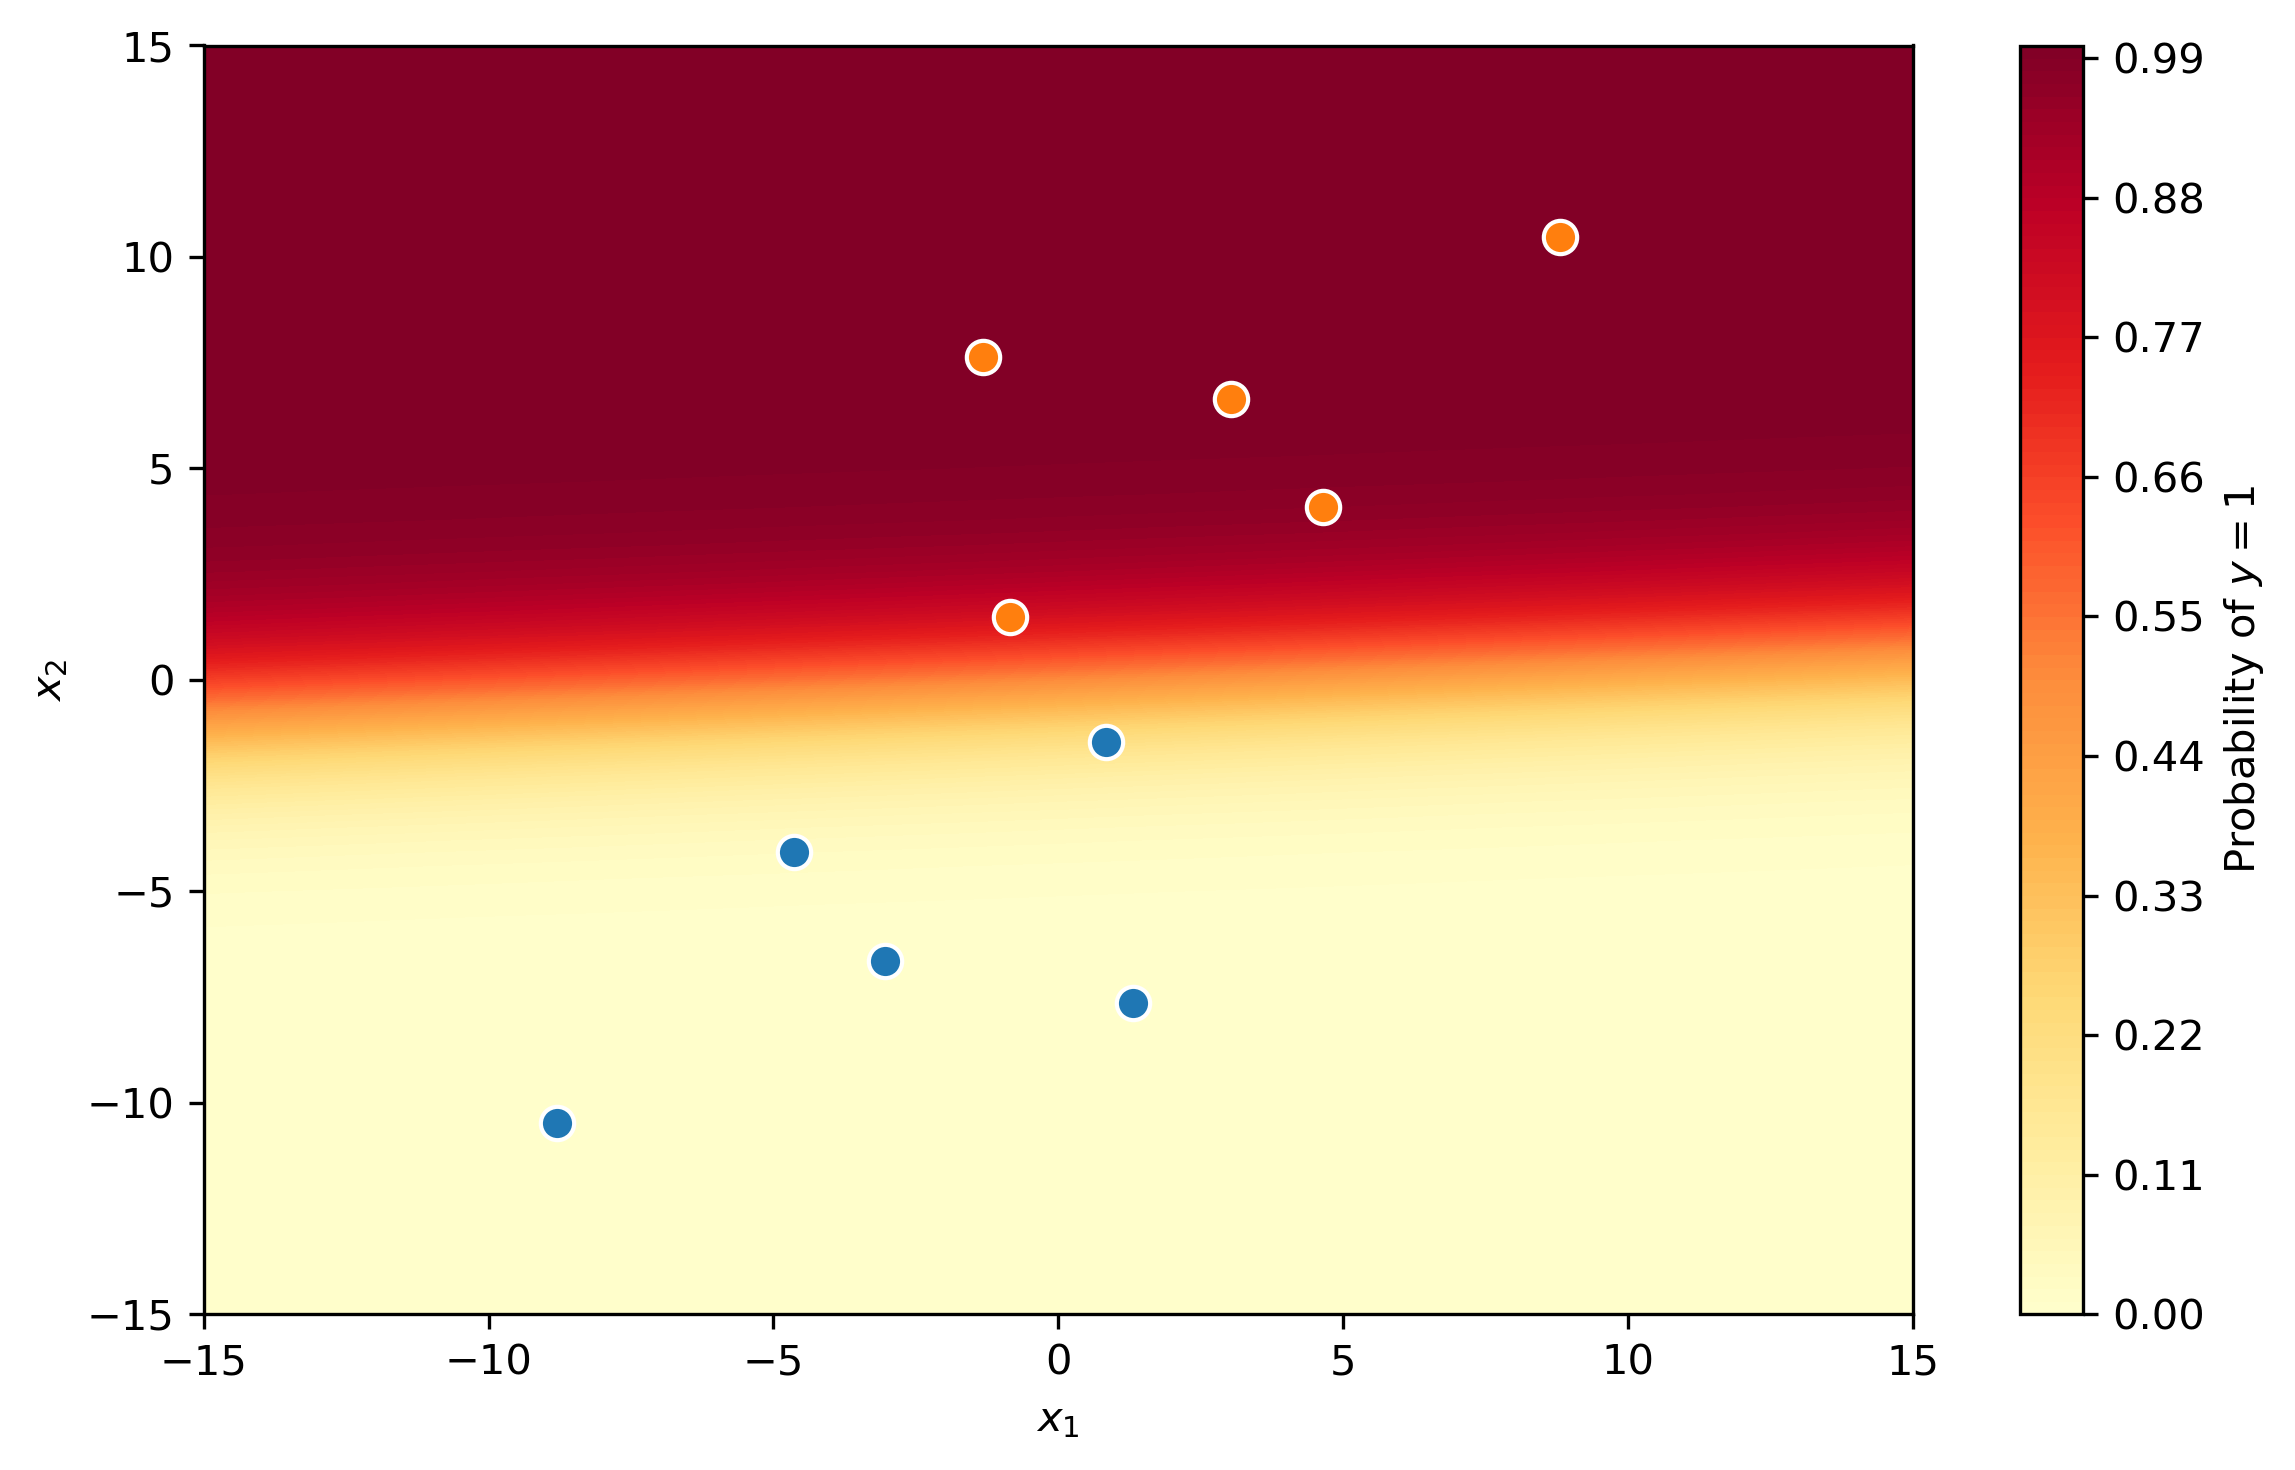

In [22]:
f, ax = plt.subplots(figsize=(8, 5))

contour = ax.contourf(X1, X2, y_pred.reshape(*X1.shape), cmap="YlOrRd", levels=101)

# training data
ax.plot(*X[:5].T, "o", ms=8, mec="w")
ax.plot(*X[5:].T, "o", ms=8, mec="w")

cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel="$x_1$", ylabel="$x_2$")
cbar.ax.set_ylabel("Probability of $y=1$")

f.tight_layout()
plt.show()

## Bayesian Logistic regression

Rather than evaluating the likelihood with a single value of theta, the Bayesian approach aims to compute the correct answer which, as we saw in the slides, should be the average likelihood, where the average is taken over the posterior distribution. The average, is calculated via a complicated integral, which we approximate with samples using MCMC. We start by creating a simple, 2 parameter logistic regression model

$$ 
y_i \sim \text{Bernoulli}(p_i) \\ 
p_i = \text{Logistic}(x_i \cdot \theta) \\
\theta_i \sim \mathcal{N}(0, 1)
$$


To draw the samples, we first write our model in NumPyro.

#### Exercise: Specify the above model in NumPyro.

In [10]:
def model(X=None, y=None):
    n_obs, n_dims = X.shape if X is not None else (10, 2)
    
    # prior
    theta = numpyro.sample("theta", dist.Normal(0, 1).expand((n_dims,)))

    # likelihood
    with numpyro.plate("n", n_obs):
        numpyro.sample("y", dist.BernoulliLogits(X @ theta), obs=y)

In [11]:
import os
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

# tell numpyro to use multiple cores
numpyro.set_host_device_count(4)

In [12]:
rng_key = random.PRNGKey(42)

mcmc = MCMC(NUTS(model), num_warmup=1000, num_samples=500, num_chains=4)
mcmc.run(rng_key, X=X, y=y)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [13]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.18      0.71      0.15     -1.01      1.33    714.12      1.00
  theta[1]      1.32      0.58      1.27      0.40      2.22    658.58      1.00

Number of divergences: 0


The mean of the coefficients does not agree with the values obtained by sklearn, but they shouldn't anyway: The mean and the mode are different quantities. When we run MCMC, though, we don't just get the means. We obtain the full distribution:

In [14]:
theta_samples = mcmc.get_samples()["theta"]

In [15]:
theta_samples.shape

(2000, 2)

Now, numpyro provides a nice api for making predictions on new data once the samples are available. However, for the sake of making this notebook as didactical as possible, I'm going to manually do what numpyro would do for you.

Say, for instance, that we want to make a prediction for a new point `x_new`. Then we do:

In [16]:
x_new = np.array([2, 0.5])
likelihoods = []
for theta in theta_samples:
    lkhood = 1 - logistic(x_new @ theta)
    likelihoods.append(lkhood)

The value we should predict is then given by ```np.mean(likelihoods)```:

In [17]:
np.mean(likelihoods)

0.3246794462185353

Let's now do it for every point on the test set:

In [18]:
bayesian_y_pred = np.zeros(X_test.shape[0])
for i, x_new in enumerate(X_test):
    p = 1 - logistic(x_new @ theta_samples.T)  # resulting likelihood for every sample
    bayesian_y_pred[i] = np.mean(p)

Let's look at the prediction boundary:

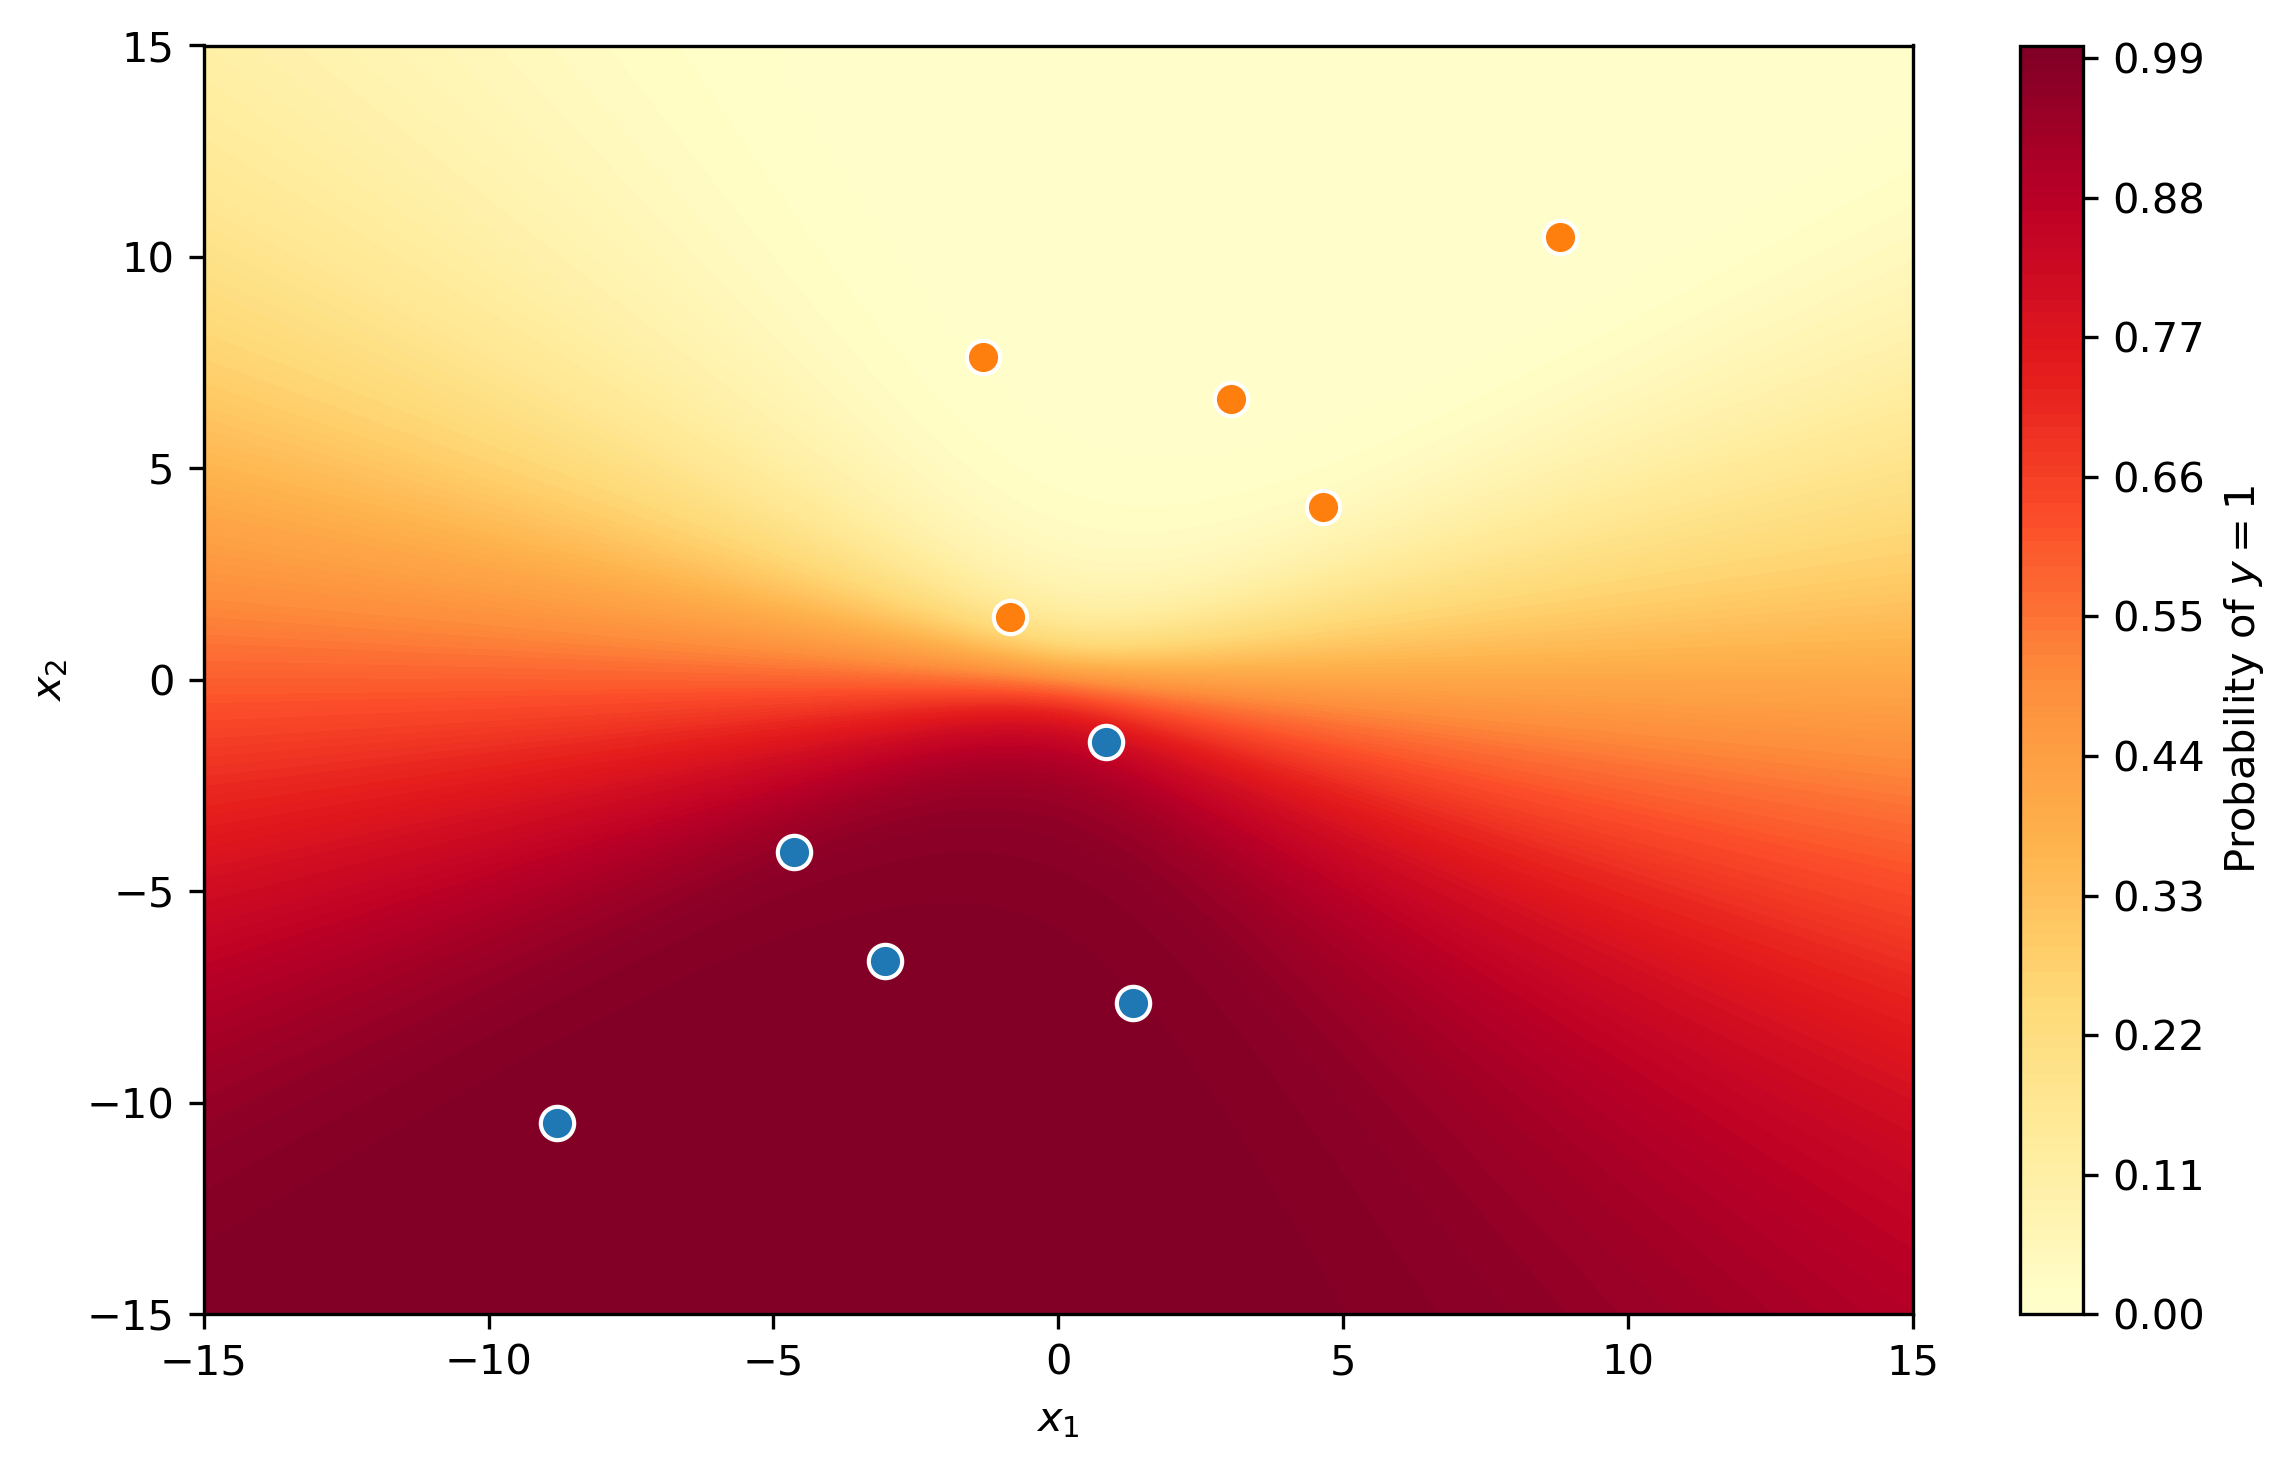

In [23]:
f, ax = plt.subplots(figsize=(8, 5))

contour = ax.contourf(X1, X2, bayesian_y_pred.reshape(*X1.shape), cmap="YlOrRd", levels=101)

# training data
ax.plot(*X[:5].T, "o", ms=8, mec="w")
ax.plot(*X[5:].T, "o", ms=8, mec="w")

cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel="$x_1$", ylabel="$x_2$")
cbar.ax.set_ylabel("Probability of $y=1$")

f.tight_layout()
plt.show()

A cool feature available to Bayesian models, is that we can also inspect the how much the predictions vary across samples -- hence serving as indicator for "model uncertainty":

In [20]:
y_pred_uncertainty = np.zeros(X_test.shape[0])
for i, x_new in enumerate(X_test):
    p = 1 - logistic(x_new @ theta_samples.T)  # resulting likelihood for every sample
    y_pred_uncertainty[i] = np.std(p)  # notice the difference to previous calculation.

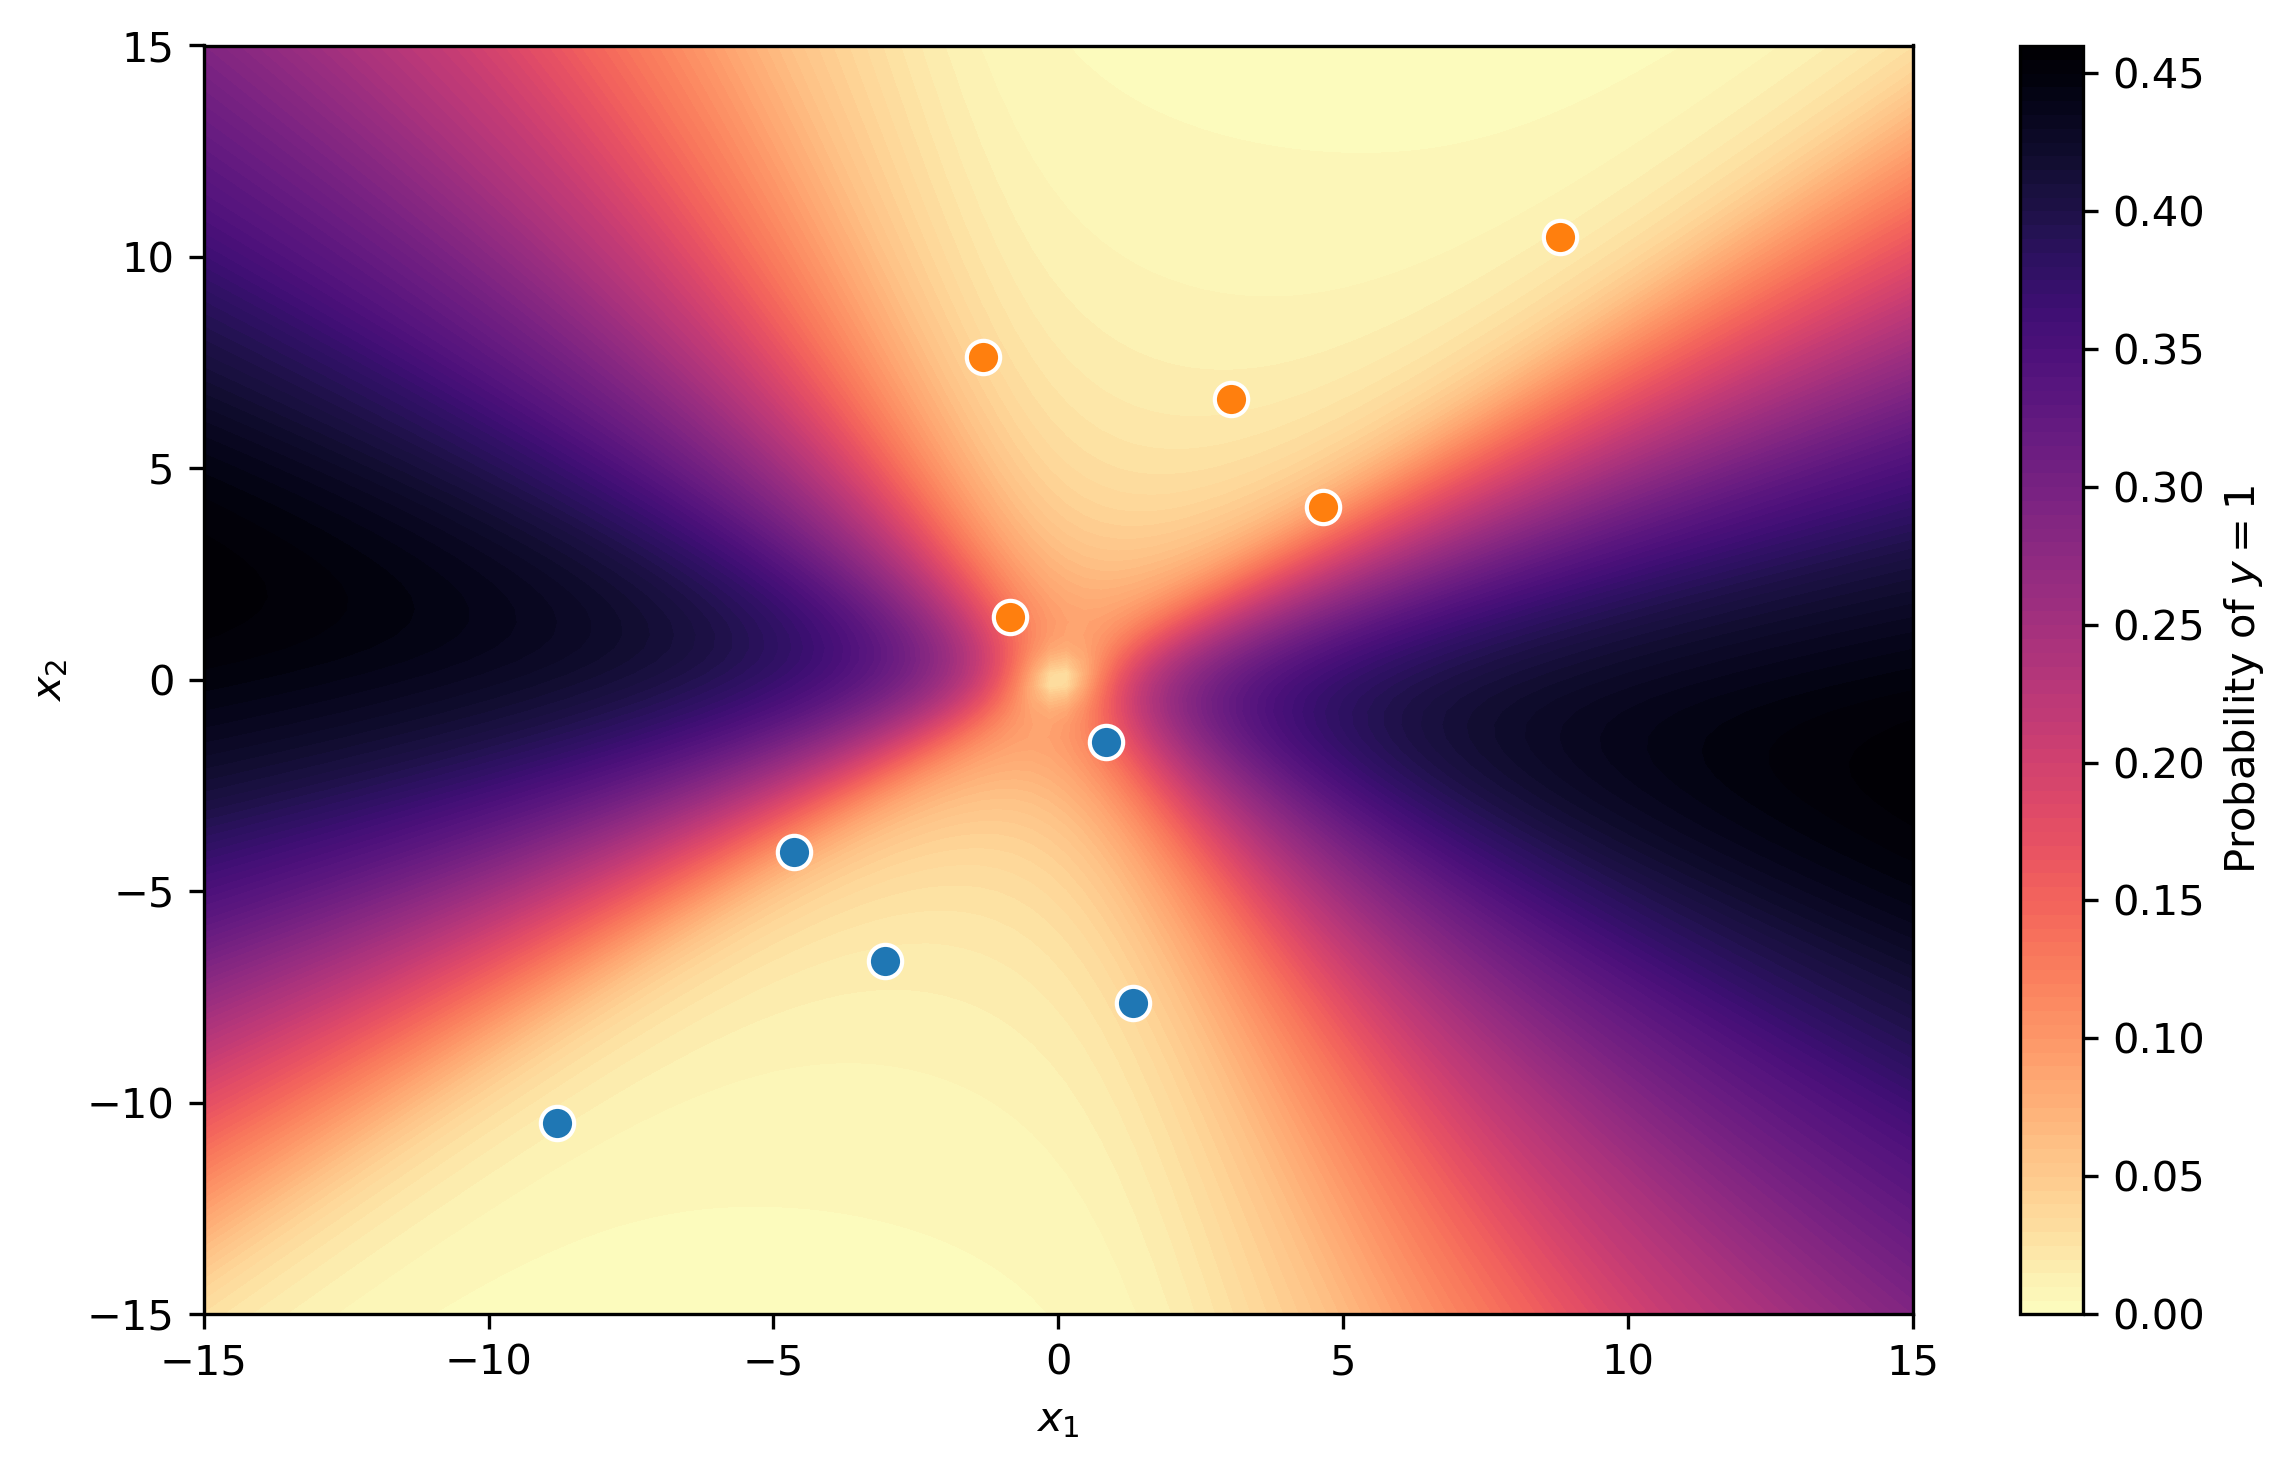

In [24]:
f, ax = plt.subplots(figsize=(8, 5))

contour = ax.contourf(X1, X2, y_pred_uncertainty.reshape(*X1.shape), cmap="magma_r", levels=100)

# training data
ax.plot(*X[:5].T, "o", ms=8, mec="w")
ax.plot(*X[5:].T, "o", ms=8, mec="w")

cbar = plt.colorbar(contour, ax=ax)
ax.set(xlabel="$x_1$", ylabel="$x_2$")
cbar.ax.set_ylabel("Probability of $y=1$")

f.tight_layout()
plt.show()

This is showing the regions of space where predictions are reliable. Basically, away from the data there is too much uncertainty and you shouldn't trust the predictions. It is extremely difficult to get a similar insight from a traditional ML model.